# Selections counter

This Notebook imports all files in [Data](../Data) and plots how many right or wrong selections were done in an experiment.

In [1]:
# Import modules
import sys
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Import custom 
sys.path.append("..") # Adds higher directory to python modules path.
from Functions import data_tools
from Functions import unity_analysis

## Import data

Import the data files contained in the [subjects](/subjects.json) file

In [2]:
# Settings
n_subjects = 2  # Number of subjects to analyze, must match JSON file

# Preallocate variables
unity_stream = [None] * n_subjects

# Import data
file = open("..\subjects.json")
json_data = json.load(file)

p300_trials = json_data["p300"]
ssvep_trial = json_data["ssvep"]
p300_trials.keys()

for i, (key, value) in enumerate(p300_trials.items()):
    [_,_,unity_stream[i]] = data_tools.import_data(f"..\\Data\\{key}\\eeg\\{value}")

Creating RawArray with float64 data, n_channels=7, n_times=609140
    Range : 0 ... 609139 =      0.000 ...  2030.463 secs
Ready.
Creating RawArray with float64 data, n_channels=23, n_times=320255
    Range : 0 ... 320254 =      0.000 ...  1067.513 secs
Ready.


## Totals

### Selections

Compute the number of `[correct, incorrect]` selections found in each stream

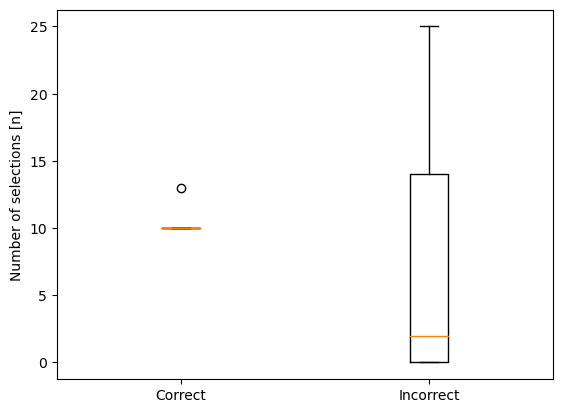

In [3]:
# Settings
plot_bar = True

total_list = unity_analysis.total_metrics(unity_stream)   # List of subjects
total_np = np.concatenate(total_list,axis=0)

if plot_bar:
    fig, ax = plt.subplots()
    plt.boxplot(total_np)
    # ax = sns.violinplot(total_np)
    ax.set_xticks([1,2], ["Correct", "Incorrect"])
    ax.set_ylabel('Number of selections [n]')
    

### Accuracy

Compute and plot accurary per subject and for all subjects. 

Total accuracy: 0.72 ± 0.13 [Mean ± SEM]


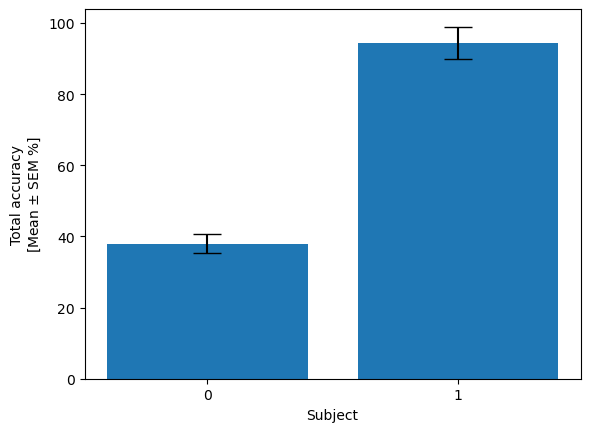

In [4]:
plot_accuracies =True

# Preallocate variables
mean_acc_per_subject = np.zeros(len(total_list))
sem_acc_per_subject = np.zeros(len(total_list))

for (s,subject) in enumerate(total_list):
    temp_accuracy = subject[:,0] / np.sum(subject, axis=1)
    mean_acc_per_subject[s] = np.mean(temp_accuracy)
    sem_acc_per_subject[s] = np.std(temp_accuracy) / np.sqrt(len(temp_accuracy))

# Total accuracy
total_acc = total_np[:,0] / np.sum(total_np, axis=1)
print(f'Total accuracy: {np.mean(total_acc):0.2f} ± {np.std(total_acc)/np.sqrt(np.shape(total_acc)[0]):0.2f} [Mean ± SEM]')

if plot_accuracies:
    fig, ax = plt.subplots()
    
    ax.bar(
        x=np.arange(n_subjects),
        height=mean_acc_per_subject*100,
        yerr=sem_acc_per_subject*100,
        capsize=10)
    ax.set_xticks(np.arange(n_subjects))
    ax.set_xlabel("Subject")
    ax.set_ylabel("Total accuracy\n[Mean $\pm$ SEM %]")
    # plt.tight_layout()
